In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import copy
import shap
import lightgbm as lgb
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split, RandomizedSearchCV, ShuffleSplit, learning_curve
import joblib

In [2]:
#Normalization
def standardize(X):
    m,n = X.shape
    
    for j in range(n):
        features = X.iloc[:,j]
        meanVal = features.mean(axis=0)
        std = features.std(axis=0)
        if std !=0:
            X.iloc[:,j]=(features-meanVal)/std
        else:
            X.iloc[:,j]=0
            
    return X

In [3]:
#Learning curve
def plot_learning_curve(estimator,title,X,y,ylim=None,cv=5,n_jobs=1,train_sizes=np.linspace(.1,1.0,5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes,train_scores,test_scores = learning_curve(estimator,X,y,cv=cv,n_jobs=n_jobs,train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores,axis=1)
    train_scores_std = np.std(train_scores,axis=1)
    test_scores_mean = np.mean(test_scores,axis=1)
    test_scores_std = np.std(test_scores,axis=1)
    plt.grid()
    
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
 
    plt.legend(loc="best")
    return plt

In [4]:
#Evaluate performance of model
def evaluate_performance(y_test, y_pred, y_prob):
    # AUROC
    auroc = metrics.roc_auc_score(y_test,y_prob)
    auroc_curve = metrics.roc_curve(y_test, y_prob)
    # AUPRC
    auprc=metrics.average_precision_score(y_test, y_prob) 
    auprc_curve=metrics.precision_recall_curve(y_test, y_prob)
    #Accuracy
    accuracy=metrics.accuracy_score(y_test,y_pred) 
    #MCC
    mcc=metrics.matthews_corrcoef(y_test,y_pred)
    
    recall=metrics.recall_score(y_test, y_pred)
    precision=metrics.precision_score(y_test, y_pred)
    f1=metrics.f1_score(y_test, y_pred)
    class_report=metrics.classification_report(y_test, y_pred,target_names = ["control","case"])

    model_perf = {"auroc":auroc,"auroc_curve":auroc_curve,
                  "auprc":auprc,"auprc_curve":auprc_curve,
                  "accuracy":accuracy, "mcc": mcc,
                  "recall":recall,"precision":precision,"f1":f1,
                  "class_report":class_report}
        
    return model_perf

In [5]:
# Output result of evaluation
def eval_output(model_perf,output_file):
    with open(output_file,'w') as f:
        f.write("AUROC=%s\tAUPRC=%s\tAccuracy=%s\tMCC=%s\tRecall=%s\tPrecision=%s\tf1_score=%s\n" %
               (model_perf["auroc"],model_perf["auprc"],model_perf["accuracy"],model_perf["mcc"],model_perf["recall"],model_perf["precision"],model_perf["f1"]))
        f.write("\n######NOTE#######\n")
        f.write("#According to help_documentation of sklearn.metrics.classification_report:in binary classification, recall of the positive class is also known as sensitivity; recall of the negative class is specificity#\n\n")
        f.write(model_perf["class_report"])

In [6]:
# Plot AUROC of model
def plot_AUROC(model_perf,output_file):
    #get AUROC,FPR,TPR and threshold
    roc_auc = model_perf["auroc"]
    fpr,tpr,threshold = model_perf["auroc_curve"]
    #plot
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='AUROC (area = %0.2f)' % roc_auc) 
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUROC of Models")
    plt.legend(loc="lower right")
    plt.savefig(output_file,format = "pdf")

In [7]:
# Plot AUPRC of model
def plot_AUPRC(model_perf,output_file):
    #get AUPRC,Precision,Recall and threshold
    prc_auc = model_perf["auprc"]
    precision,recall,threshold = model_perf["auprc_curve"]
    #plot
    plt.figure()
    lw = 2
    plt.figure(figsize=(10,10))
    plt.plot(recall, precision, color="red",
             lw=lw, label='AUPRC (area = %0.2f)' % prc_auc) 
    plt.plot([0, 1], [1, 0], color="navy", lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("AUPRC of Models")
    plt.legend(loc="lower right")
    plt.savefig(output_file,format = "pdf")

In [8]:
#Random seed
SEED = np.random.seed(2020)

In [9]:
############ Data Processing ###########
print("\n...... Processing Data ......\n")

#Load data
dataset = pd.read_csv("/picb/lilab5/datasets/machinelearning/datasets/sum/four_classes.csv",sep = '\t',index_col=0)
control = pd.read_csv("/picb/lilab5/datasets/machinelearning/datasets/sum/control.csv",sep = '\t',index_col=0)

#Case samples
case_samples = dataset[dataset["case_or_control"] == "case"] #7975

#Control samples
control_samples = control#382037
partial_control_samples = control_samples.sample(len(case_samples),random_state = SEED) 

#Concat case and partial control
new_dataset = pd.concat([case_samples,partial_control_samples]) #15950

#Samples_label "control":0 , "case":1
label_dict = {"control":0 , "case":1}
samples_label =  np.array(new_dataset["case_or_control"].apply(lambda x:label_dict[x]))

#Normalization
content = new_dataset.iloc[:,0:-1]
X = standardize(content)
#Input
X = copy.deepcopy(X)
y = copy.deepcopy(samples_label)

#TrainingSet : TestSet = 4 : 1
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = SEED)

print("\n...... Finished Data Processing ......\n")
########################################


...... Processing Data ......


...... Finished Data Processing ......



In [10]:
########## Model Construction ##########
print("\n...... Training Model ......\n")

# LightGBM params
param_dict = {
    "learning_rate":[0.1, 0.05, 0.02, 0.015, 0.01],
    "num_leaves": range(0,36,5),
    "max_depth" : [-1,2,3,4,5,10,20,40,50],
    "min_data_in_leaf": range(1, 45, 2),
    "feature_fraction" : [i / 10 for i in range(2,11)],
    "metric" : ["binary_logloss"],
    "early_stopping_rounds" : [None],
    "n_jobs" : [-1],
    "silent" : [True],
    "verbose" : [-1],
    "n_estimators" : range(50,1000,50),
    "bagging_fraction" :  [i / 10 for i in range(2, 11)],
    "bagging_freq" : [0, 1, 2],
    "lambda_l1" : [0, 0.001, 0.005, 0.01, 0.1],
    "lambda_l2" : [0, 0.001, 0.005, 0.01, 0.1],
    "objective":["binary"],
    "random_state":[2020]
}

#Initiate model
model = lgb.LGBMClassifier()
#Adjust hyper-parameters with 5-fold cross validation
rscv = RandomizedSearchCV(model, param_dict, n_iter=100,cv = 5,verbose = 0,
                          scoring = "roc_auc", n_jobs =-1)
rscv.fit(X_train, y_train)   

#save model
#joblib.dump(rscv.best_estimator_, "lightgbm_best_model.pkl")
#load model
#gbm = joblib.load("lightgbm_best_model.pkl")

print("\n...... Finished Model Construction ......\n")
######################################


...... Training Model ......



Found `early_stopping_rounds` in params. Will use it instead of argument


[LightGBM] [Warning] lambda_l1 is set=0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] min_data_in_leaf is set=27, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=27
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] lambda_l2 is set=0, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0

...... Finished Model Construction ......



<module 'matplotlib.pyplot' from '/picb/lilab5/yushijia/anaconda3/lib/python3.8/site-packages/matplotlib/pyplot.py'>

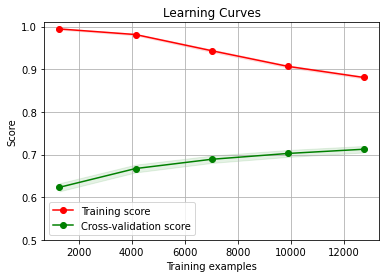

In [11]:
#Learning curve
title=r"Learning Curves"
cv=ShuffleSplit(n_splits=100, test_size=0.2, random_state=2020)
estimator=rscv.best_estimator_
plot_learning_curve(estimator,title,X,y,ylim=(0.5,1.01),cv=cv,n_jobs=16)


...... Evaluating Model ......


...... Finished Model Evaluation ......



<Figure size 432x288 with 0 Axes>

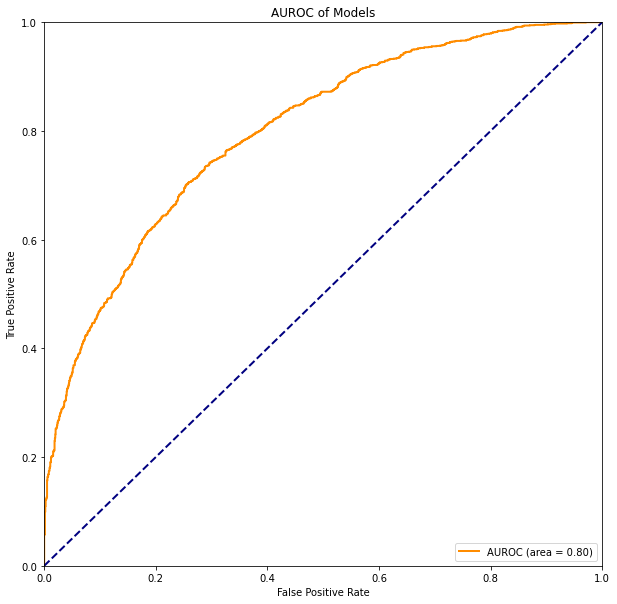

<Figure size 432x288 with 0 Axes>

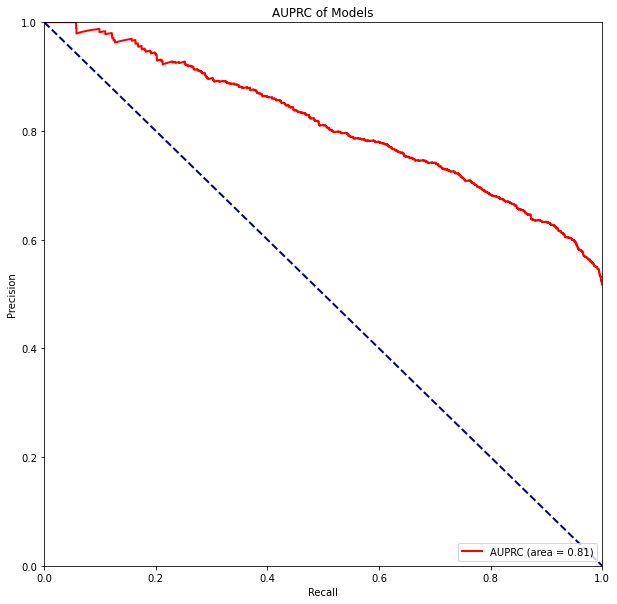

In [12]:
########## Model Evaluation ##########
print("\n...... Evaluating Model ......\n")

#Get best model with score [max(mean(auc(5 cross validation)))]
best_model = rscv.best_estimator_
#Get predict_class(y_pred) and predict_probality_for_case(y_prob) of TestSet
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:,1]

#Get model performance
model_perf = evaluate_performance(y_test,y_pred,y_prob)

#Output result of evaluation
eval_output(model_perf,"/picb/lilab5/yushijia/LightGBM_Blood/Evaluate_Result_TestSet_lgbfull.txt")
#You can make bar plot consisted of accuracy,sensitivity,specificity,auroc,f1 score,precision,recall,auprc according to the "Evaluate_Result_TestSet.txt"

#Plot
# plot AUROC AUPRC
plot_AUROC(model_perf,"/picb/lilab5/yushijia/LightGBM_Blood/AUROC_TestSet_lgbfull.pdf")
plot_AUPRC(model_perf,"/picb/lilab5/yushijia/LightGBM_Blood/AUPRC_TestSet_lgbfull.pdf")

print("\n...... Finished Model Evaluation ......\n")
######################################

LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray



This is an overview of which features are most important(top 20) represented by SHAP values of every feature for every sample



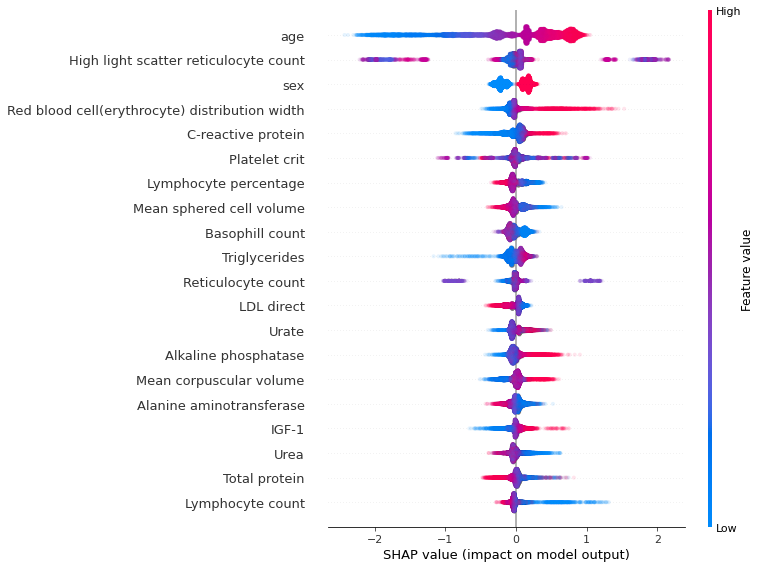


This is an overview of which features are most important(top 20) represented by mean absolute value of the SHAP values for each feature



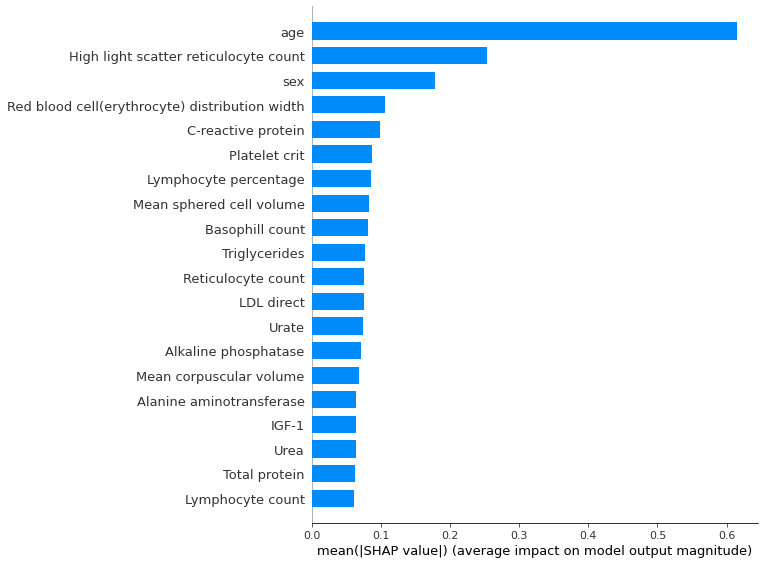


This is a heatmap for shap interaction values of most important(top 20) features



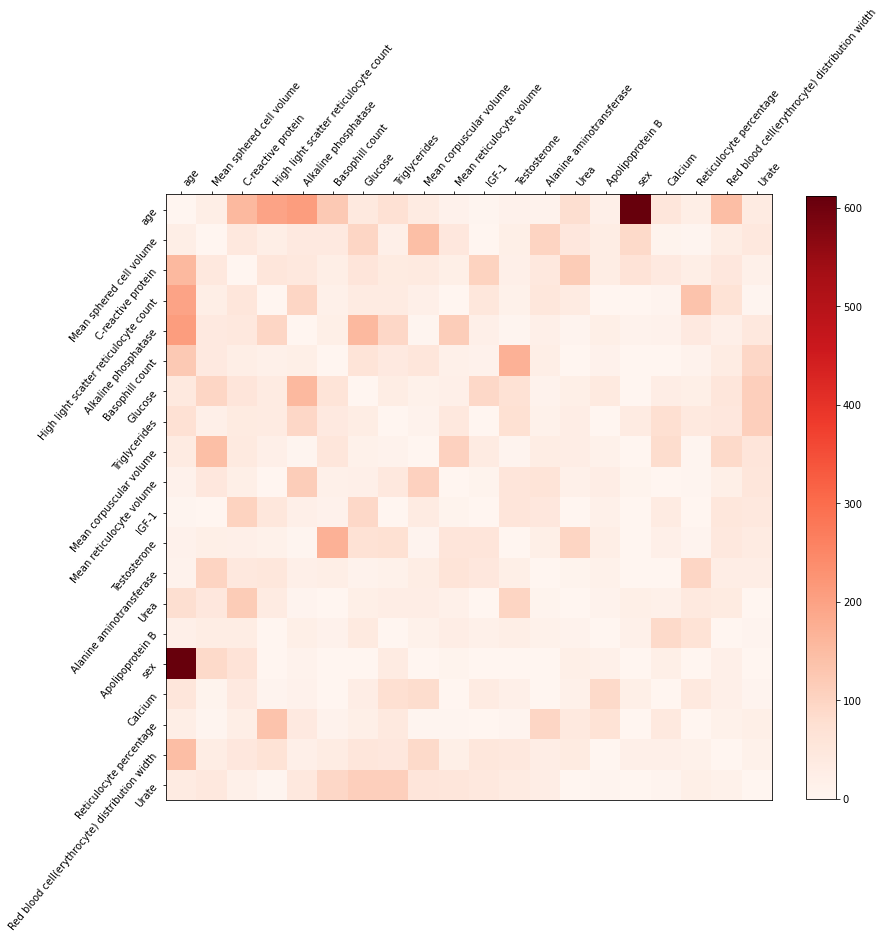


######### Two instances of shap interaction are the following########


First instance: Glycated haemoglobin (HbA1c) and Cystatin C


shap main effect of Glycated haemoglobin (HbA1c)


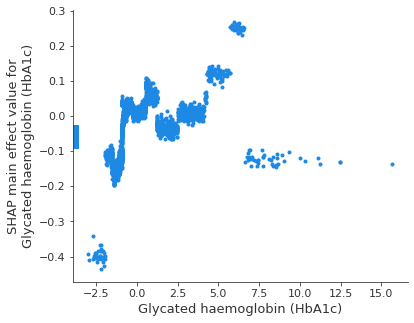


shap main effect of Cystatin C


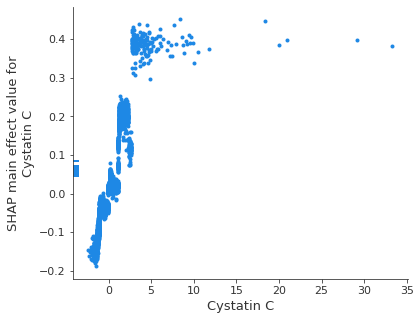


shap interaction value of Glycated haemoglobin (HbA1c) and Cystatin C


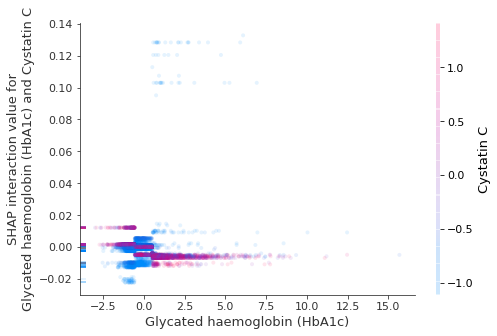


shap interaction value of Cystatin C and Glycated haemoglobin (HbA1c)


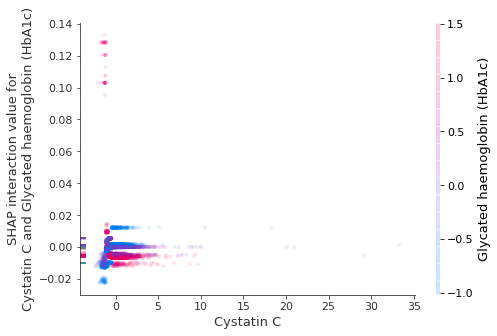


shap value for Glycated haemoglobin (HbA1c) coloured with expression of Cystatin C


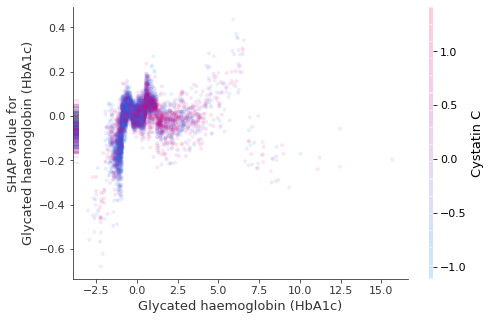


shap value for Cystatin C coloured with expression of Glycated haemoglobin (HbA1c)


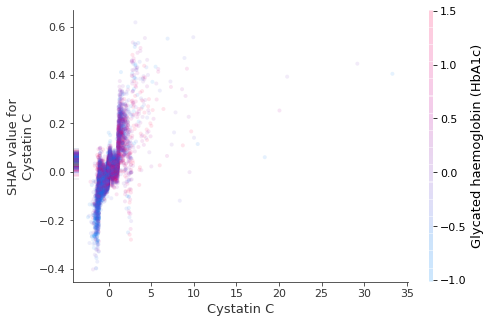


Second instance: Red blood cell(erythrocyte) distribution width and Cystatin C


shap main effect of Red blood cell(erythrocyte) distribution width


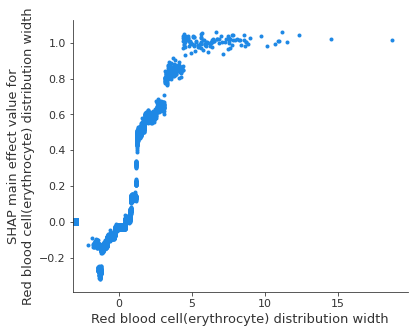


shap main effect of Cystatin C


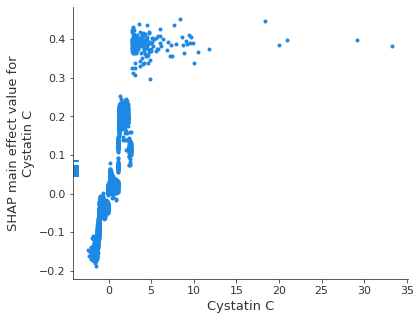


shap interaction value of Red blood cell(erythrocyte) distribution width and Cystatin C


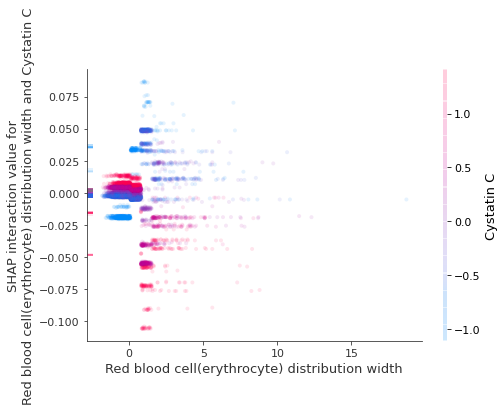


shap interaction value of Cystatin C and Red blood cell(erythrocyte) distribution width 


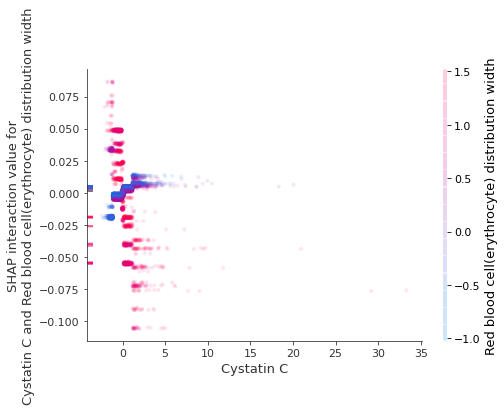


shap value for Red blood cell(erythrocyte) distribution width coloured with expression of Cystatin C


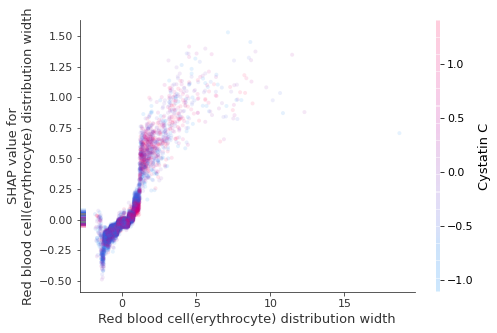


shap value for Cystatin C coloured with expression of Red blood cell(erythrocyte) distribution width


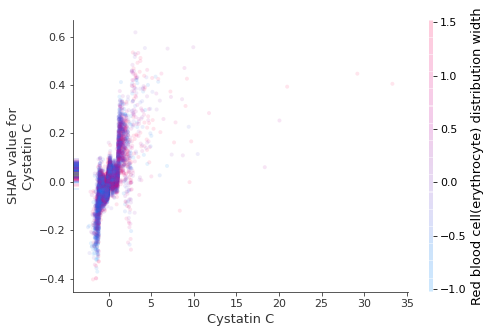


...... Finished Model Interpretation ......



In [13]:
shap.initjs() 
#Explain the model's predictions on the entire dataset for cancer case 
explainer = shap.TreeExplainer(rscv.best_estimator_) 
shap_values = explainer.shap_values(X)[1]

#Plot the SHAP values of every feature(top 20) for every sample 
print("\nThis is an overview of which features are most important(top 20) represented by SHAP values of every feature for every sample\n") 
shap.summary_plot(shap_values, X,max_display = 20,alpha=0.1) 
#Plot the mean absolute value of the SHAP values for each feature(top 20)
print("\nThis is an overview of which features are most important(top 20) represented by mean absolute value of the SHAP values for each feature\n") 
shap.summary_plot(shap_values, X,plot_type="bar",max_display = 20)

#If you want to save shap plot as pdf,just modify the following code 
#fig = shap.summary_plot(shap_values, X, show=False,max_display = 20) 
#plt.savefig("shap.pdf", format='pdf', dpi=1000, bbox_inches='tight')

#Get shap interaction values 
shap_interaction_values = explainer.shap_interaction_values(X) 
#Plot heatmap of shap interaction values 
print("\nThis is a heatmap for shap interaction values of most important(top 20) features\n") 
tmp = np.abs(shap_interaction_values).sum(0) 
for i in range(tmp.shape[0]): 
    tmp[i,i] = 0 
inds = np.argsort(-tmp.sum(0))[:20] 
tmp2 = tmp[inds,:][:,inds] 
plt.figure(figsize=(12,12)) 
plt.imshow(tmp2,cmap = "Reds") 
plt.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right") 
plt.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left") 
plt.colorbar(fraction=0.045, pad=0.05) 
plt.gca().xaxis.tick_top() 
plt.show()

#Instances of shap interaction 
print("\n######### Two instances of shap interaction are the following########\n")

#1
print("\nFirst instance: Glycated haemoglobin (HbA1c) and Cystatin C\n") 
#Glycated haemoglobin(HbA1c) and Cystatin C
#shap main effect of Glycated haemoglobin(HbA1c) and Cystatin C
print("\nshap main effect of Glycated haemoglobin (HbA1c)") 
shap.dependence_plot( ("Glycated haemoglobin (HbA1c)", "Glycated haemoglobin (HbA1c)"), shap_interaction_values, X, display_features=X )
print("\nshap main effect of Cystatin C") 
shap.dependence_plot( ("Cystatin C", "Cystatin C"), shap_interaction_values, X, display_features=X ) 


#shap interaction value of Glycated haemoglobin(HbA1c) and Cystatin C 
print("\nshap interaction value of Glycated haemoglobin (HbA1c) and Cystatin C") 
shap.dependence_plot( ("Glycated haemoglobin (HbA1c)", "Cystatin C"), shap_interaction_values, X, display_features=X,alpha=0.1 )
print("\nshap interaction value of Cystatin C and Glycated haemoglobin (HbA1c)") 
shap.dependence_plot( ("Cystatin C", "Glycated haemoglobin (HbA1c)"), shap_interaction_values, X, display_features=X,alpha=0.1 )

#shap value for Glycated haemoglobin (HbA1c) coloured with expression of Cystatin C
#& Cystatin C coloured with expression of Glycated haemoglobin (HbA1c)
print("\nshap value for Glycated haemoglobin (HbA1c) coloured with expression of Cystatin C") 
shap.dependence_plot("Glycated haemoglobin (HbA1c)", shap_values, X,interaction_index ="Cystatin C",alpha=0.1)
print("\nshap value for Cystatin C coloured with expression of Glycated haemoglobin (HbA1c)") 
shap.dependence_plot("Cystatin C", shap_values, X,interaction_index ="Glycated haemoglobin (HbA1c)",alpha=0.1)

#2
print("\nSecond instance: Red blood cell(erythrocyte) distribution width and Cystatin C\n") 
#Red blood cell(erythrocyte) distribution width and Cystatin C
#shap main effect of Red blood cell(erythrocyte) distribution width and Cystatin C
print("\nshap main effect of Red blood cell(erythrocyte) distribution width") 
shap.dependence_plot( ("Red blood cell(erythrocyte) distribution width", "Red blood cell(erythrocyte) distribution width"), shap_interaction_values, X, display_features=X )
print("\nshap main effect of Cystatin C") 
shap.dependence_plot( ("Cystatin C", "Cystatin C"), shap_interaction_values, X, display_features=X ) 


#shap interaction value of Red blood cell(erythrocyte) distribution width and Cystatin C 
print("\nshap interaction value of Red blood cell(erythrocyte) distribution width and Cystatin C") 
shap.dependence_plot( ("Red blood cell(erythrocyte) distribution width", "Cystatin C"), shap_interaction_values, X, display_features=X,alpha=0.1 )
print("\nshap interaction value of Cystatin C and Red blood cell(erythrocyte) distribution width ") 
shap.dependence_plot( ("Cystatin C", "Red blood cell(erythrocyte) distribution width"), shap_interaction_values, X, display_features=X,alpha=0.1 )

#shap value for Red blood cell(erythrocyte) distribution width coloured with expression of Cystatin C
#& Cystatin C coloured with expression of Red blood cell(erythrocyte) distribution width
print("\nshap value for Red blood cell(erythrocyte) distribution width coloured with expression of Cystatin C") 
shap.dependence_plot("Red blood cell(erythrocyte) distribution width", shap_values, X,interaction_index ="Cystatin C",alpha=0.1)
print("\nshap value for Cystatin C coloured with expression of Red blood cell(erythrocyte) distribution width") 
shap.dependence_plot("Cystatin C", shap_values, X,interaction_index ="Red blood cell(erythrocyte) distribution width",alpha=0.1)

print("\n...... Finished Model Interpretation ......\n")